# Mental Health sentiment prediction using  Deep Learning with Advanced Tensorflow Techniques

Data source - https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

## 1. Import the neccsary Libraries

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from bs4 import BeautifulSoup
import string
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
stop_words = ENGLISH_STOP_WORDS

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

## 2. Loading the data from google drive storage

### We store it in a pandas dataframe for preprocessing and oreparation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
file_path = '/content/drive/My Drive/Combined Data.csv'
df = pd.read_csv(file_path)

### Lets check the shape to see how many data items and attributes we have

In [7]:
df.shape

(53043, 3)

### Next lets get a look at the first 5 rows

In [8]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## 3. Data Preprocessing


### We see here that statement and status is all we care about
### So next we set our dataframe to only those two columns

In [9]:
df = df[['statement', 'status']]
df.shape

(53043, 2)

In [10]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


### The status column represents the sentiment we hope to predict so lets look at the classes

In [11]:
df['status'].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


### Here we can look at some exanples of data items of the specific categories

In [12]:
df[df['status']=='Depression'].head()
# df[df['status']=='Normal'].head()
# df[df['status']=='Bipolar'].head()
# df[df['status']=='Suicidal'].head()
# df[df['status']=='Personality disorder'].head()

,statement,status
6982,I recently went through a breakup and she said...,Depression
6983,"I do not know how to navigate these feelings, ...",Depression
6984,"So I have been with my bf for 5 months , and h...",Depression
6986,I have been severly bullied since i was 5 till...,Depression
6988,My mom made me go to a camp that she knows I h...,Depression


### Next we check for any missing values and their class

In [13]:
df.isnull().sum()

,0
statement,362
status,0


In [14]:
df[df['statement'].isnull()]['status'].value_counts()

,count
status,
Personality disorder,124
Bipolar,100
Stress,82
Anxiety,47
Normal,8
Suicidal,1


### We drop the missing values

In [15]:
df = df.dropna()
df.isnull().sum()

,0
statement,0
status,0


### Next we encode our label for the mental health status as One Hot Encoding
### The classes have no order amongst them so this is a preffered option rather than Label encoding the classes(0,1,2...6)

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])
label_encoder.classes_



array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

In [17]:
df.head()

,statement,status
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0


In [18]:
  import nltk
  nltk.download('punkt')
  from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Next we clean the text

* stem removal
* removing punctuation marks
* converting all text to lower case
* removing stop words


In [19]:


# Initialize the stemmer
stemmer = PorterStemmer()


punctuation_chars = string.punctuation + '-'
table = str.maketrans('', '', punctuation_chars)

sentences = []
for sentence in df['statement'].fillna('').str.lower():
    # Check if the sentence is not NaN (float in pandas)
    if isinstance(sentence, str):
        soup = BeautifulSoup(sentence, 'html.parser')
        sentence = soup.get_text()
        words = word_tokenize(sentence)

        # Remove stop words
        words = [word for word in words if word.lower() not in stop_words]

        # Apply stemming
        words = [stemmer.stem(word) for word in words]

        filtered_sentence = " ".join([word.translate(table) for word in words])
        sentences.append(filtered_sentence)
    else:
        sentences.append("")  # Replace NaN with an empty string

# Remove 'text' from sentences (if it exists)
sentences = [s.replace('text ', '') for s in sentences]

# Add the preprocessed sentences back to the DataFrame
df['statement'] = sentences

<ipython-input-19-84b648e82da9>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, 'html.parser')


In [20]:
df.head()

,statement,status
0,oh gosh,0
1,troubl sleep confus mind restless heart tune,0
2,wrong dear forward doubt stay restless rest...,0
3,ve shift focu m worri,0
4,m restless restless s month boy mean,0


### Next we convert the text to bag of words using TFIDF
### The BOW vector represantation will be our features

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=5, stop_words="english")
X = vect.fit_transform(df['statement'])


### We take a look at the number of features we will have

In [22]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 10614
First 20 features:
['00' '000' '0000' '009' '00b' '01' '010' '02' '025mg' '05' '07' '08' '09'
 '0am' '0f' '0hr' '0k' '0mg' '0th' '0x']
Features 20010 to 20030:
[]
Every 2000th feature:
['00' 'cola' 'gasolin' 'mild' 'ruler' 'ur']


### Next we have a look at the features with the lowest tfidf and those with highest tfidf

Features with lowest tfidf: These features appear frequently across all documents and thus are less useful to distinguish between classes.

Features with highest tfidf: These are terms that are very specific to certain documents and can be strong indicators to classify those documents.

In [23]:
max_value = X.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vect.get_feature_names_out())
print("Features with lowest tfidf:\n{}".format(
 feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
 feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['algo' 'tempo' 'vez' 'downey' '1830' 'payton' 'ucc' 'womani' 'ao'
 'epitom' 'suicidali' 'kilogram' 'cliqu' 'unsustain' 'promiscu' 'redact'
 'defer' 'abusei' 'existenci' 'tee']
Features with highest tfidf: 
['spirit' 'song' 'soon' 'disgust' 'did' 'spici' 'sore' 'sorri' 'sooo'
 'soy' 'sou' 'âœ' '1230' 'ðÿ' 'yawn' 'yell' 'yeji' 'ye' '11' '10th']


## 4. Train Test Splits

### We split our data into train test splits
### Given the small dataset we use 80% for the train set and 20% for the test set which wil actually be the validation set.

In [24]:
Y = df['status']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((42144, 10614), (10537, 10614), (42144,), (10537,))

## 5. Model Training

### We setup our distribution strategy, which in this case we will be using the TPU Strategy

In [25]:
import random
tf.__version__
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print('Running on TPU:', tpu.master())
  print('Number of accelerators:', strategy.num_replicas_in_sync)
except ValueError:
  print("TPU failed to initialize")

Running on TPU: 
Number of accelerators: 8


### We have 8 TPU Cores to train across

### We setup the Batch size and num of classes

In [26]:
BATCH_SIZE = 128
num_classes = len(label_encoder.classes_)

num_classes

7

### Setup the model architecture

In [27]:
def base_model():
  inputs = tf.keras.Input(shape=(1, X_train.shape[1],))
  x = LSTM(128, return_sequences=True)(inputs)
  x = Dropout(0.2)(x)
  x = LSTM(128)(x)
  x = Dropout(0.2)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  return model

### Initialize the model within the scope of our strategy
### Then also setup model paramaterrs and train and test steps

In [33]:
with strategy.scope():
  model = base_model()
  loss_object = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions):


    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE* strategy.num_replicas_in_sync)

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
  test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

  optimizer = tf.keras.optimizers.Adam()

  @tf.function
  def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    print(per_replica_losses)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

  @tf.function
  def distributed_test_step(dataset_inputs):
    strategy.run(test_step, args=(dataset_inputs,))

  def train_step(inputs):
    images, labels = inputs
    with tf.GradientTape() as tape:

      predictions = model(images, training=True)
      labels = tf.one_hot(labels, depth=7)  # One-hot encode numerical labels
      print("Shape of labels:", labels.shape)  # Print shape of labels
      print("Shape of predictions:", predictions.shape)  # Print shape of predictions
      loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)
    return loss

  def test_step(inputs):
    images, labels = inputs
    # One-hot encode the labels within the test_step function
    labels = tf.one_hot(labels, num_classes)
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss.update_state(t_loss)
    test_accuracy.update_state(labels, predictions)

### Convert our datasets to tensorflow dataset format for batching and convert to distribute dataset format

In [34]:

train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train.toarray(), axis=1), Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_test.toarray(), axis=1), Y_test))

In [35]:

train_dataset = train_dataset.shuffle(2048)
# Reshape data to (batch_size, 1, num_features) BEFORE batching

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True) # Add drop_remainder=True
train_dataset = train_dataset.prefetch(AUTO)

test_dataset = test_dataset.shuffle(2048)
# Reshape data to (batch_size, 1, num_features) BEFORE batching

test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True) # Add drop_remainder=True
test_dataset = test_dataset.prefetch(AUTO)

In [36]:
training_dataset = strategy.experimental_distribute_dataset(train_dataset)
testing_dataset = strategy.experimental_distribute_dataset(test_dataset)

### We train the model for 10 Epochs while keeping track of the perfomance metrics

In [37]:

EPOCHS = 10
with strategy.scope():
  for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0
    for x in training_dataset:
      total_loss += distributed_train_step(x)
      num_batches += 1
    train_loss = total_loss / num_batches

    for x in testing_dataset:
      distributed_test_step(x)
    template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, "
                "Test Accuracy: {:.2f}")
    print(template.format(epoch + 1, train_loss,
                          train_accuracy.result() * 100, test_loss.result(),
                          test_accuracy.result() * 100))

    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Shape of labels: (16, 7)
Shape of predictions: (16, 7)
PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
Shape of labels: (16, 7)
Shape of predictions: (16, 7)
PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_s

## 7. Evaluation

### The last test accuracy was around 70%
### Next we calcualte the f1 score and then the confusion matrix

In [38]:
import matplotlib.pyplot as plt

In [54]:


# Calculate the F1 Score and plot the confusion matrix
from sklearn.metrics import confusion_matrix, f1_score

# Create a TensorFlow Dataset

X_test_dense = X_test.toarray()

# Now you can convert it to a TensorFlow tensor
X_test_tensor = tf.convert_to_tensor(X_test_dense)

# Create a TensorFlow Dataset
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test_tensor)
X_test_tensor = X_test_tensor.batch(BATCH_SIZE)
# Reshape X_test_tensor to include the extra dimension
X_test_tensor = X_test_tensor.map(lambda x: tf.expand_dims(x, axis=1))

y_pred = model.predict(X_test_tensor)


y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(Y_test, y_pred, average='weighted')
print("F1 Score:", f1)

conf_matrix = confusion_matrix(Y_test, y_pred)



83/83 [==============================] - 4s 19ms/step
F1 Score: 0.7237922738168906


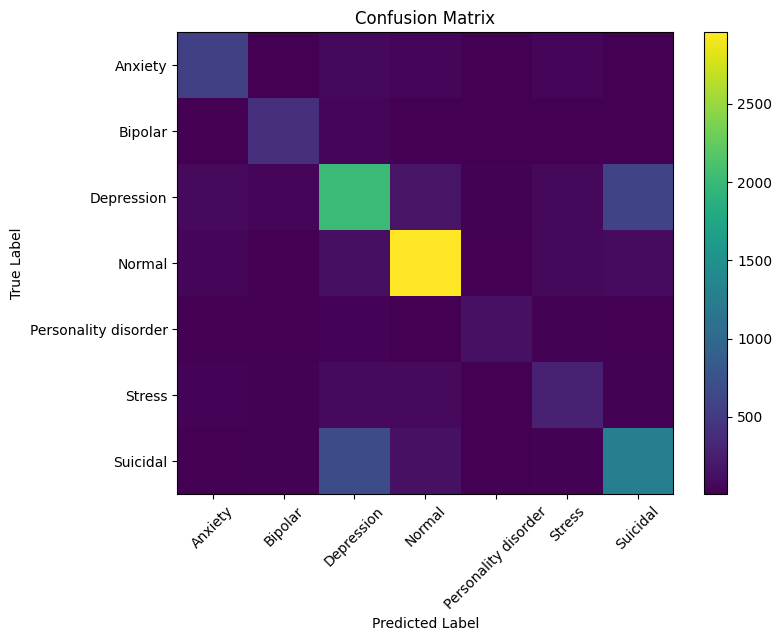

In [55]:
# Plot the confusion matrix with labels
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis', aspect='auto') # Changed plt.cm to 'viridis' as the colormap
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Both F1 Score and test accuracy were around 70% suggesting our model is doign decently well but there is room for improvement
### When the training stopped the training accuracy was still increasing contrary to the test accuracy which was showing signs of decreasing
### This suggests overfitting
### Options are to decrease the model complexity or introduce more regularization
### But given the small dataset that we have the most likely reason for model overfiitting is lack of data
### Ultimatley the task was to train a Deep Learning model with advanced tensorflow techniques and that was achieved other options such as getting a larger dataset are rooms for improvement.